# Amplitude Amplification Operators

The main objective of present library is use quantum algorithms for computing the expected value of a function $f(x)$ when the $x$ variable follows a probability distribution $p(x)$: $E_{x\sim p}(f)$. This is computed as:

$$E_{x\sim p}(f)=\int_a^bp(x)f(x)dx$$

For solving this integral we are going to use a procedure based on Grover algorithm called **Amplitude Amplification**.

In the notebook **01_DataLoading_Module_Use.ipynb**  the first mandatory steps for using this procedure was explained: the loading of the probability density $p(x)$ (loading operator $\mathcal{P}$) and the loading of an array that represents the function $f(x)$ (loading operator $\mathcal{F}$).

Second step for **Amplitude Amplification** procedure is the creation of a Grover-like operator based on the $\mathcal{P}$ and $\mathcal{F}$ operators. Present notebook review the **amplitude_amplification** module where all the mandatory functions for creating this Grover-like operator ($\hat{Q}$) were stored.

Present notebook and module are based on the following references:

* *Brassard, G., Hoyer, P., Mosca, M., & Tapp, A. (2000). Quantum amplitude amplification and estimation.AMS Contemporary Mathematics Series, 305. https://arxiv.org/abs/quant-ph/0005055v1*
* NEASQC deliverable: *D5.1: Review of state-of-the-art for Pricing and Computation of VaR https://www.neasqc.eu/wp-content/uploads/2021/06/NEASQC_D5.1_Review-of-state-of-the-art-for-Pricing-and-Computation-of-VaR_R2.0_Final.pdf*

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
import qat.lang.AQASM as qlm 
from copy import deepcopy

In [3]:
%load_ext qat.core.magic

The qat.core.magic extension is already loaded. To reload it, use:
  %reload_ext qat.core.magic


In [4]:
global_qlmaas = True
try:
    from qlmaas.qpus import LinAlg
except (ImportError, OSError) as e:
    global_qlmaas = False
from qat.qpus import PyLinalg

In [5]:
def get_qpu(qlmass=False):
    """
    Function for selecting solver. User can chose between:
    * LinAlg: for submitting jobs to a QLM server
    * PyLinalg: for simulating jobs using myqlm lineal algebra.

    Parameters
    ----------

    qlmass : bool
        If True  try to use QLM as a Service connection to CESGA QLM
        If False PyLinalg simulator will be used

    Returns
    ----------
    
    lineal_qpu : solver for quantum jobs
    """
    if qlmass:
        if global_qlmaas:
            print('Using: LinAlg')
            linalg_qpu = LinAlg()
        else:
            raise ImportError("""Problem Using QLMaaS.Please create config file or use mylm solver""")
            
    else:
        print('Using PyLinalg')
        linalg_qpu = PyLinalg()
    return linalg_qpu

In [6]:
#QLMaaS == False -> uses PyLinalg
#QLMaaS == True -> try to use LinAlg
QLMaaS = False
linalg_qpu = get_qpu(QLMaaS)

Using PyLinalg


In [7]:
sys.path.append("../../")
from my_lib.utils import  get_histogram
from my_lib.data_extracting import get_results

## 1. Data Discretization

The operators $\mathcal{P}$ and $\mathcal{F}$ need discretized arrays of the probability and the function to be loaded into the quantum state.

In [8]:
def p(x):
    return x*x
def f(x):
    return np.sin(x)

In [48]:
#number of Qbits for the circuit
n_qbits = 4
#The number of bins 
m_bins = 2**n_qbits
LowerLimit = 0.0
UpperLimit = 1.0 

X, p_X = get_histogram(p, LowerLimit, UpperLimit, m_bins)
f_X = f(X)

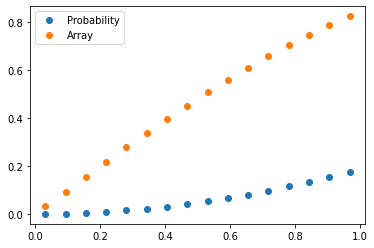

In [49]:
%matplotlib inline
plt.plot(X, p_X, 'o')
plt.plot(X, f_X, 'o')
plt.legend(['Probability', 'Array'])

## 2. Complete Data Loading

In order to use the **Amplitude Amplification** procedure first step is loading the complete data ($p(x)$ and $f(x)$) into a quantum state. In this section a fast review of this step si presented.

If we begin with a typical initial $n+1$ quantum state: $|0\rangle_{n}\otimes|0\rangle_{1}$. The complete loading procces executes following operation:

$$|\Psi\rangle=\mathcal{F}\left(\mathcal{P}\otimes I\right)|0\rangle_{n}\otimes|0\rangle_{1}$$

Where:

* $\mathcal{P}$ is the probability loading operator (note that it acts on an $n$ qbit state). **load_probability** function from **data_loading** will be used.
* $\mathcal{F}$ is the function loading operator (note that it acts on an $n+1$ qbit state). **load_array** function from **data_loading** will be used


### 2.1 $\mathcal{P}$ with using **load_probability**

In [50]:
from my_lib.data_loading import load_probability

In [51]:
p_gate = load_probability(p_X)

In [52]:
%qatdisplay p_gate --depth 0

In order to show how $\mathcal{P}$ acts we can use **get_results** function from **data_extracting** script. This function needs following arguments:

* A QLM routine, abstract, gate or program
* A QLM solver (argument linalg_qpu)
* number of shots for executing circuit in the simulation (0 will calculate True probabilities)
* qubits: list of qbits to be measured (if None all qbits will be measured)

In [53]:
results, circuit, q_p, job = get_results(p_gate, linalg_qpu=linalg_qpu, shots=0)

In this case wee need to sort all the results using the **Int_lsb** column

In [54]:
results.sort_values('Int_lsb')

,Probability,States,Amplitude,Int,Int_lsb
0,0.000183,|0000>,0.013538+0.000000j,0,0
8,0.001650,|1000>,0.040615+0.000000j,8,1
4,0.004582,|0100>,0.067691+0.000000j,4,2
12,0.008981,|1100>,0.094768+0.000000j,12,3
2,0.014846,|0010>,0.121844+0.000000j,2,4
10,0.022177,|1010>,0.148921+0.000000j,10,5
6,0.030975,|0110>,0.175997+0.000000j,6,6
14,0.041239,|1110>,0.203074+0.000000j,14,7
1,0.052969,|0001>,0.230150+0.000000j,1,8
9,0.066166,|1001>,0.257227+0.000000j,9,9


In [55]:
p_X

array([0.00018328, 0.00164956, 0.00458211, 0.00898094, 0.01484604,
       0.02217742, 0.03097507, 0.041239  , 0.05296921, 0.06616569,
       0.08082845, 0.09695748, 0.11455279, 0.13361437, 0.15414223,
       0.17613636])

In [56]:
#Test for correct loading
print('Test OK: {}'.format(np.isclose(results.sort_values('Int_lsb')['Probability'].values, p_X).all()))

Test OK: True


### 2.2 $\mathcal{F}$ with using **load_array**

In [57]:
from my_lib.data_loading import load_array

In [58]:
#In order to load a function f(x) we need to provide sqrt(f(x))
f_gate = load_array(np.sqrt(f_X))

In [59]:
%qatdisplay f_gate --depth 0

For testing the function loading operator $\mathcal{F}$, first a equally probability superposition of states is needed. The function **uniform_distribution** from **data_loading** will be used.
In this case the desired integral $E_{x\sim U}(f)$ (the expected value of a function $f(x)$ over a variable $x$ that follows an uniform probability distribution) is loading as the amplitude of the state $|0\rangle$ in the last qbit.


In [60]:
from my_lib.data_loading import uniform_distribution

In [61]:
q_rout = qlm.QRoutine()
q_bit = q_rout.new_wires(f_gate.arity)
#Uniform distribution
q_rout.apply(uniform_distribution(f_gate.arity-1),q_bit[:f_gate.arity-1])
q_rout.apply(f_gate, q_bit)
results, circuit, q_p, job = get_results(q_rout, linalg_qpu=linalg_qpu, shots=0, qubits=[f_gate.arity-1])

In [62]:
%qatdisplay circuit --depth 0

In [63]:
results

,Probability,States,Amplitude,Int,Int_lsb
0,0.459773,|0>,None,0,0
1,0.540227,|1>,None,1,1


In [64]:
#Desired Integral
results['Probability'].iloc[0]*2**(n_qbits)

7.356360371927307

In [65]:
sum(f_X)

7.35636037192731

In [66]:
#Load Integral Testing
print('Test OK: {}'.format(np.isclose(results['Probability'].iloc[0]*2**(n_qbits), sum(f_X))))

Test OK: True


### 2.3 $\mathcal{PF}$ operator

For creating the Grover-like operator we need only one Operator so we need to create a unique operator from $\mathcal{P}$ and $\mathcal{F}$. 

We can create the routine manually or use the  **load_pf** function provide in the module

#### Manually creation of the operator

In [67]:
pf_gate = qlm.QRoutine()
q_bits = pf_gate.new_wires(f_gate.arity)
pf_gate.apply(p_gate, q_bits[:p_gate.arity])
pf_gate.apply(f_gate, q_bits)

In [68]:
#%qatdisplay p_gate
#%qatdisplay r_gate
%qatdisplay pf_gate --depth 0


For this case the desired integral $E_{x\sim p}(f)$ (the expected value of a function $f(x)$ over a variable $x$ that follows an probability distribution $p(x)$). 
And again this integral was loaded as the amplitude of the state $|0\rangle$ in the last qbit.


In [69]:
results, circuit, q_p, job = get_results(pf_gate, linalg_qpu=linalg_qpu, shots=0, qubits=[pf_gate.arity-1])

In [70]:
results

,Probability,States,Amplitude,Int,Int_lsb
0,0.6693,|0>,None,0,0
1,0.3307,|1>,None,1,1


In [71]:
sum(p_X*f_X)

0.6693004071633366

In [72]:
#Testing Expected value of the function
print('Test OK: {}'.format(np.isclose(sum(p_X*f_X), results['Probability'][results['Int_lsb']==0])))

Test OK: [ True]


#### Using load_pf function

In [73]:
from my_lib.data_loading import load_pf

In [74]:
pf_gate = load_pf(p_gate, f_gate)

In [75]:
%qatdisplay pf_gate --depth 1

In [76]:
results, circuit, q_p, job = get_results(pf_gate, linalg_qpu=linalg_qpu, shots=0, qubits=[pf_gate.arity-1])

In [77]:
results

,Probability,States,Amplitude,Int,Int_lsb
0,0.6693,|0>,None,0,0
1,0.3307,|1>,None,1,1


In [39]:
sum(p_X*f_X)

0.6697058522082925

In [40]:
#Testing Expected value of the function
print('Test OK: {}'.format(np.isclose(sum(p_X*f_X), results['Probability'][results['Int_lsb']==0])))

Test OK: [ True]


# 3. Amplitude Amplification: Grover-like operator $\mathcal{Q}$

The quantum state resulting from the loading proccess: $|\Psi\rangle$ can be expressed as a linear combination of two orthogonal states $|\Psi_{1}\rangle$ y $|\Psi_{0}\rangle$:

$$|\Psi\rangle=\sqrt{a}|\Psi_{0}\rangle+\sqrt{1-a}|\Psi_{1}\rangle$$

Where $|\Psi_{0}\rangle$ and $|\Psi_{1}\rangle$ are the following orthonormal states:

$$|\Psi_{1}\rangle = \sum_{x=0}^{2^{n}-1}|x\rangle^{n}\otimes\frac{1}{\sqrt{1-a}}\sqrt{p(x)(1-f(x))}|1\rangle$$
$$|\Psi_{0}\rangle = \sum_{x=0}^{2^{n}-1}|x\rangle^{n}\otimes\frac{1}{\sqrt{a}}\sqrt{p(x)f(x)}|0\rangle$$


Where $|x\rangle^{n}$ is a notation for a quantum state of n qbits.


The idea behind Quantum Amplitude Amplification procedure is increase the probability of the $|\Psi_{0}\rangle$  using a strategy based on the Grover Algorithm. 

An Operator $\mathcal{Q}$ should be applied an optimal number of times $k$ in order to maximize probability of measure $|\Psi_{0}\rangle$. 

The Grover-like operator $\mathcal{Q}$ is composed of 2 different operators:

$$\mathcal{Q}=\hat{U}_{|\Psi\rangle} \hat{U}_{|\Psi_{0}\rangle}$$

Where $\hat{U}_{|\Psi\rangle}$ y $\hat{U}_{|\Psi_{0}\rangle}$ are:

$$\hat{U}_{|\Psi_{0}\rangle } = \hat{I} - 2|\Psi_{0}\rangle \langle \Psi_{0}|$$
$$\hat{U}_{|\Psi\rangle } = \hat{I} - 2|\Psi\rangle\langle \Psi|$$

**amplitude_amplification** module have all the functions for creating properly QLM AbstractGates for these operators. 

In this section we are going to review all the operators programed for creating the Grover-like operator. We want to test the output of each programed operator so first we are going to do the loading data procedure and get the results of this proccess for comparing purpouses when each new operator will be presented.

### 3.1 Data Loading Step

In [41]:
def p(x):
    return x*x
def f(x):
    return np.sin(x)

#number of Qbits for the circuit
n_qbits = 5
#The number of bins 
m_bins = 2**n_qbits
LowerLimit = 0.0
UpperLimit = 1.0 

X, p_X = get_histogram(p, LowerLimit, UpperLimit, m_bins)
f_X = f(X)

In [42]:
#First we prepare the data loading procces

from my_lib.data_loading import load_probability, load_array, load_pf

p_gate = load_probability(p_X)
#In order to load a function f(x) we need to provide sqrt(f(x))
f_gate = load_array(np.sqrt(f_X))
pf_gate = load_pf(p_gate, f_gate)


#Getting the complete initial state
Phi_State, circuit, q_prog, job = get_results(pf_gate, linalg_qpu=linalg_qpu, shots=0)
#For getting the state of the additional qbit where the desired integral are stored
Initial_State, circuit, q_p, job = get_results(pf_gate, linalg_qpu=linalg_qpu, shots=0, qubits=[pf_gate.arity-1])

In [43]:
#Complete state
Phi_State.head()

,Probability,States,Amplitude,Int,Int_lsb
0,3.577006e-07,|000000>,0.000598+0.000000j,0,0
1,2.253607e-05,|000001>,0.004747+0.000000j,1,32
2,1.229310e-02,|000010>,0.110874+0.000000j,2,16
3,1.263822e-02,|000011>,0.112420+0.000000j,3,48
4,1.736861e-03,|000100>,0.041676+0.000000j,4,8


In [44]:
#State of the auxiliar qbit
Initial_State

,Probability,States,Amplitude,Int,Int_lsb
0,0.669625,|0>,None,0,0
1,0.330375,|1>,None,1,1


### 3.2 Operador $\hat{U}_{|\Psi_{0}\rangle}$

First mandatory operator is:

$$\hat{U}_{|\Psi_{0}\rangle } = \hat{I} - 2|\Psi_{0}\rangle \langle \Psi_{0}|$$

Equivalent circuit for the operator is:

$$\hat{U}_{|\Psi_{0}\rangle }=(\hat{I_{n}}\otimes X)(\hat{I_{n}}\otimes Z)(\hat{I_{n}}\otimes X)$$

with the $\hat{I_{n}}$ we want ro remark that the identity operator $\hat{I}$ acts over the first $n$ qbits


Apply this operator on state $|\Psi\rangle$:

$$\hat{U}_{|\Psi_{0}\rangle} |\Psi\rangle = \sqrt{1-a}|\Psi_{1}\rangle-\sqrt{a}|\Psi_{0}\rangle$$

So operator $\hat{U}_{|\Psi_{0}\rangle }$ do a reflection operation around the axis defined by the state $|\Psi_{1}\rangle$

Abstract Gate **uphi0_gate** from **amplitude_amplification** allow us do the operation. We need to provide as input the numbe of the qbits of the gate

In [45]:
from my_lib.amplitude_amplification import uphi0_gate

In [46]:
UPhi0_Gate = uphi0_gate(pf_gate.arity)

In [47]:
%qatdisplay UPhi0_Gate --depth 1

In [ ]:
#Apply the UPhi0_Gate to the data loading circuit
qProg_Uphi0 = deepcopy(q_prog)
registers = qProg_Uphi0.registers
qProg_Uphi0.apply(UPhi0_Gate, registers)
UPhi0_State, circuit, _, _ = get_results(qProg_Uphi0, linalg_qpu=linalg_qpu, shots=0)

In [ ]:
%qatdisplay circuit --depth 1

In [ ]:
UPhi0_State.sort_values('Int_lsb')

The operation done by the **uphi0_gate** is:

$$\hat{U}_{|\Psi_{0}\rangle} |\Psi\rangle = \sqrt{1-a}|\Psi_{1}\rangle-\sqrt{a}|\Psi_{0}\rangle$$

Or in a graphic view:

![title](OraculeReflection.png)

For testing the operator we need to check that: 
* Sates with final qbit $|0\rangle$ ($|\Psi_{0}\rangle$) change the sign with respect to the initial state $|\Psi\rangle$ 
* States with final qbit in $|1\rangle$ ($|\Psi_{1}\rangle$) are the same that in the initial state $|\Psi\rangle$

In [ ]:
#Testing Final qbit |0> should be of different sign
LastQbit0 = np.isclose(
    np.array([p for s,p in zip(Phi_State['States'], Phi_State['Amplitude']) if s.bitstring[-1] == '0']),
    -np.array([p for s,p in zip(UPhi0_State['States'], UPhi0_State['Amplitude']) if s.bitstring[-1] == '0'])
).all()
#Testing Final qbit |1> should be of same sign
LastQbit1 = np.isclose(
    np.array([p for s,p in zip(Phi_State['States'], Phi_State['Amplitude']) if s.bitstring[-1] == '1']),
    np.array([p for s,p in zip(UPhi0_State['States'], UPhi0_State['Amplitude']) if s.bitstring[-1] == '1'])
).all()

In [ ]:
print('Test OK: {}'.format((LastQbit0 and LastQbit1)))

### 3.2 Operador $\hat{U}_{|\Psi\rangle}$

Operator $\hat{U}_{|\Psi\rangle}$ is the equivalent to the Grover's difusor operator:

$$\hat{U}_{|\Psi\rangle } = \hat{I} - 2|\Psi\rangle\langle \Psi|$$

Additionally we know that:

$$|\Psi\rangle=\mathcal{F}\left(\mathcal{P}\otimes I\right)|0\rangle_{n}\otimes|0\rangle_{1}$$


Then the operator can be decomposed in the following way:

$$\hat{U}_{|\Psi\rangle } =\mathcal{F}\left(\mathcal{P}\otimes I\right)\hat{D}_{0} \left(\mathcal{P}\otimes I\right)^{\dagger} \mathcal{F}^{\dagger}$$

Where $\hat{D}_{0}$ is a reflection around the perpendicular state to $|0^{n+1}\rangle$

$$\hat{D}_{0} = \hat{I}-2|0^{n+1}\rangle\langle0^{n+1}|$$

In this case $|0^{n+1}\rangle$ is the zero state for n+1 qbits

#### 3.2.1 Implementación  $\hat{D}_{0}$

The equivalent circuit for $\hat{D}_{0}$ is:

$$\hat{D}_{0} = \hat{I}-2|0^{n+1}\rangle\langle0^{n+1}|= \hat{X}^{\otimes n+1} c^{n}Z \hat{X}^{\otimes n+1}$$

The *AbstractGate* **d0_gate** from **amplitude_amplification** allow us create the operator.  We need to provide as input the numbe of the qbits of the gate

In [ ]:
from my_lib.amplitude_amplification import d0_gate

In [ ]:
D0 = d0_gate(pf_gate.arity)

In [ ]:
%qatdisplay D0 --depth 1

In [ ]:
#Apply the d0_gate to the data loading circuit
qProg_D0 = deepcopy(q_prog)
registers = qProg_D0.registers
qProg_D0.apply(D0, registers)
UD0_State, circuit, _, _ = get_results(qProg_D0, linalg_qpu=linalg_qpu, shots=0)

In [ ]:
%qatdisplay circuit --depth 1

In [ ]:
UD0_State

Operator $\hat{D}_{0}$ over state  $|\Psi\rangle$:

$$\hat{D}_{0}|\Psi\rangle = \hat{I}|\Psi\rangle-2|0^{n+1}\rangle\langle0^{n+1}|\Psi\rangle^{n+1}$$


It can be demostrated that the only difference between $\hat{D}_{0}|\Psi\rangle$ and $|\Psi\rangle$ is that the component $|0^{n+1}\rangle$ the sign changes!!

In [ ]:
#Testing
C01 = np.isclose(Phi_State['Amplitude'].loc[0], -UD0_State['Amplitude'].loc[0])
C02 = np.isclose(Phi_State['Amplitude'].loc[1:], UD0_State['Amplitude'].loc[1:]).all()

In [ ]:
print('Test OK: {}'.format((C01 and C02)))

#### 3.2.2 Implementation  $\hat{U}_{|\Psi}\rangle$

Finally the function **load_uphi_gate** from **amplitude_amplification** creates a customized AbstractGate that implements $\hat{U}_{|\Psi\rangle }$. This functions needs the initial $\mathcal{PF}$ gate used for loading the complete data.

This operator is reflection around the ortoghonal state to $|\Psi\rangle$.

In [ ]:
from my_lib.amplitude_amplification import load_uphi_gate
UPhi = load_uphi_gate(pf_gate)

In [ ]:
%qatdisplay UPhi --depth 1

In [ ]:
#Apply the UPhi to the data loading circuit
qProg_Diff = deepcopy(q_prog)
registers = qProg_Diff.registers
qProg_Diff.apply(UPhi, registers)
DiffPhi_State, circuit, _, _ = get_results(qProg_Diff, linalg_qpu=linalg_qpu, shots=0)

In [ ]:
%qatdisplay circuit --depth 1

The $\hat{U}_{|\Psi\rangle}$ (**diffusor**) is a reflection around the state $|\Psi\rangle^{\perp}$ (where $|\Psi\rangle^{\perp} \perp |\Psi\rangle$).

Using the graphic representation:

![title](StateReflection.png)

So:

$$\hat{U}_{|\Psi\rangle } |\Psi\rangle = \hat{I}|\Psi\rangle - 2|\Psi\rangle \langle \Psi|\Psi\rangle$$

$$\hat{U}_{|\Psi\rangle } |\Psi\rangle = |\Psi\rangle - 2|\Psi\rangle = -|\Psi\rangle$$



In [ ]:
DiffPhi_State

In [ ]:
#Testing: the resulted state is opposite to the initial state
print('Test OK: {}'.format(np.isclose(DiffPhi_State['Amplitude'], - Phi_State['Amplitude']).all()))

## 4. Operador $\mathcal{Q}$

Finally we can implement the desired Grover-like Operator $\mathcal{Q}$:

$$\mathcal{Q}=\hat{U}_{|\Psi\rangle} \hat{U}_{|\Psi_{0}\rangle}$$

This operator is created using the function **load_q_gate** from **amplitude_amplification**. The gate for loading the complete data ($\mathcal{PF}$) should be provided


In [78]:
from my_lib.amplitude_amplification import load_q_gate

In [79]:
q_gate = load_q_gate(pf_gate)

In [82]:
%qatdisplay q_gate --depth 3

In [ ]:
#Apply the Q Grover-like operator to the data loading circuit
qProg_Q = deepcopy(q_prog)
registers = qProg_Q.registers
qProg_Q.apply(q_gate, registers)
QPhi_State, circuit, _, _ = get_results(qProg_Q, linalg_qpu=linalg_qpu, shots=0, qubits = [q_gate.arity-1])

In [ ]:
#Complete circuit
%qatdisplay circuit --depth 1

In [ ]:
QPhi_State

To test if operator was implemented properly we know that the quantum state resulting from the complete loading proccess $|\Psi\rangle_{n+1}$ can be expressed as a linear combination of twor othogonal states $|\Psi_{1}\rangle$ and $|\Psi_{0}\rangle$:

$$|\Psi\rangle=\sqrt{a}|\Psi_{0}\rangle+\sqrt{1-a}|\Psi_{1}\rangle$$

where:

$$a = \sum_{x=0}^{2^{n}-1} p(x)f(x)$$

Making the following identities:

* $\sqrt{a} = \cos{\theta}$
* $\sqrt{1-a} = \sin{\theta}$
* $ a = \sum_{n=0}^{2^{n}-1} p(x)f(x) = \cos^{2}{\theta}$

Then:

$$|\Psi\rangle=\sin{\theta}|\Psi_{1}\rangle+\cos{\theta}|\Psi_{0}\rangle$$

So using the initial state we are going to calculate $\theta$.

In [ ]:
Initial_State

The operator $\hat{Q}$ can be viewed as a Y-Rotation of $\theta$ on $|\Psi\rangle$: 

![title](GroverGeometrico.png)

$$\hat{Q}|\Psi\rangle= \hat{R}_{y}(2*\theta)|\Psi\rangle=\hat{R}_{y}(2*\theta)(\sin{\theta}|\Psi_{1}\rangle+\cos{\theta}|\Psi_{0}\rangle) = \sin{3\theta}\Psi_{1}\rangle+\cos{3\theta}|\Psi_{0}\rangle$$

So starting from $|\Psi\rangle$ we can obtain the angle $\theta$

In [ ]:
#First get the Amplitudes for Phi state
a0 = np.sqrt(Initial_State.iloc[0]['Probability'])
a1 = np.sqrt(Initial_State.iloc[1]['Probability'])

In [ ]:
#Calculating Theta using the quantum state from loading data: LResults
def GetAngle(Array):
    Modulo = np.linalg.norm(Array)
    cosTheta = Array[0]/Modulo
    Theta0 = np.arccos(cosTheta)
    sinTheta = Array[1]/Modulo
    Theta1 = np.arcsin(sinTheta)
    #print(Modulo, cosTheta, sinTheta, Theta0, Theta1)
    return Theta0

#Quantum state after loading data: |Psi>
Psi_ = np.array([a0, a1])
#Angle between |Psi> and axis |Psi_0>
theta = GetAngle(Psi_)
print('theta: {}'.format(theta))
print('Psi_: {}'.format(Psi_))

Now we have $\theta$ and the $|\Psi\rangle$

In [ ]:
#In order to test that this theta is ok we can compute it from p(x) and f(x)
a = sum(p_X*f_X)
sqrt_a = np.sqrt(a)
theta2 = np.arccos(sqrt_a)
print('theta2: {}'.format(theta2))

print('Is theta equals to theta2: {}'.format(np.isclose(theta, theta2)))

As explained before, application of $\hat{Q}$ operator is equivalent to apply Rotation of angle $2\theta$ to state $|\Psi\rangle$:

In [ ]:
#Create a Rotation of 2*theta
c, s = np.cos(2*theta), np.sin(2.*theta)
#Rotation matrix
R = np.array(((c, -s), (s, c)))
#Apply Ry(2*theta) to quantum state |Psi>
RotationResults = np.dot(R, Psi_)

In [ ]:
RotationResults

So in this case the Rotated vector should be the state correspondient to the operation: $\hat{Q}|\Psi\rangle$. In our case we have the probabilities for $\hat{Q}|\Psi\rangle$ so we can square the Rotated Vector and compared with the probabilities.

This is done in the following cells:


In [ ]:
print('Square Of Rotated Vector: {}'.format(RotationResults**2))
print('Probabilities for QPhi_State: {} '.format(list(QPhi_State['Probability'])))
print('Square of the RotateState equal to Probabilities of Q|Phi> state : {}'.format(
    np.isclose(RotationResults**2, QPhi_State['Probability']).all())
     )

In [ ]:
print('Test OK: {}'.format(np.isclose(RotationResults**2, QPhi_State['Probability']).all()))

In [ ]:
QPhi_State

As can be seen the application of a Rotation of $2*\theta$ on $|\Psi\rangle$ give us the same proability configuration that apply a $\hat{Q}|\Psi\rangle$. 

## 5. Operator $\mathcal{Q}^n$

In the script **amplitude_amplification.py** a **load_qn_gate** function was programed. This function receives an input gate and apply it a desired number of times

In [ ]:
from my_lib.amplitude_amplification import load_q_gate, load_qn_gate

In [ ]:
q_n_gate = load_qn_gate(q_gate, 4)
%qatdisplay q_n_gate --depth 1